In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128


In [2]:
!pip install transformers numpy scikit-learn matplotlib seaborn Pillow

DATA AUGMENTATION AND MIXING. 1:1 ratio of Normal and Stroke classes.

In [3]:
import os
import random
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

IMAGE_SIZE = (256, 256)

# --- Augmentation pipelines ---

classic_augment = T.Compose([
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.Normalize(mean=[0.5], std=[0.5])
])

unmix_augment = T.Compose([
    T.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.Normalize(mean=[0.5], std=[0.5])
])

# Mixing function
def mix_tensors(t1, t2, alpha=0.5):
    return alpha * t1 + (1 - alpha) * t2

# --- Paths ---
input_folder = "Dataset"
output_folder = "Balanced_dataset"
os.makedirs(output_folder, exist_ok=True)

# --- Dataset ---
resize_and_tensor = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor()
])
dataset = ImageFolder(root=input_folder, transform=resize_and_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# --- Class specific config ---
augmentation_counts = {
    "Normal": {"classic": 5, "mixed": 4},  # +1 original = 10
    "Stroke": {"classic": 10, "mixed": 9}  # +1 original = 20
}

# --- Build class index map for mixing ---
class_to_indices = {}
for idx, (path, label) in enumerate(dataset.imgs):
    class_name = dataset.classes[label]
    class_to_indices.setdefault(class_name, []).append(idx)

# --- Save function ---
def save_image(tensor, path):
    tensor = tensor * 0.5 + 0.5  # Unnormalize
    pil = T.ToPILImage()(tensor.squeeze(0))
    pil.save(path)

def save_augmented_images(image_tensor, image_name, class_name, output_folder, classic_n, mixed_n):
    class_folder = os.path.join(output_folder, class_name)
    os.makedirs(class_folder, exist_ok=True)

    # Save original
    save_image(image_tensor, os.path.join(class_folder, f"{image_name}_orig.png"))

    # Classic augmentations
    for i in range(classic_n):
        aug_tensor = classic_augment(image_tensor)
        save_image(aug_tensor, os.path.join(class_folder, f"{image_name}_aug_{i}.png"))

    # Mixing augmentations
    indices_pool = class_to_indices[class_name]
    for i in range(mixed_n):
        other_idx = random.choice(indices_pool)
        other_img_path = dataset.imgs[other_idx][0]
        other_img = Image.open(other_img_path).convert("RGB")
        other_img = other_img.resize(IMAGE_SIZE)
        other_tensor = T.ToTensor()(other_img).unsqueeze(0)

        mixed = mix_tensors(image_tensor, other_tensor, alpha=random.uniform(0.4, 0.6))
        mixed = unmix_augment(mixed)
        save_image(mixed, os.path.join(class_folder, f"{image_name}_mix_{i}.png"))

# --- Main loop ---
print("🚀 Starting image augmentation and mixing...")

for idx, (image_tensor, label) in enumerate(dataloader):
    image_path = dataset.imgs[idx][0]
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    class_name = dataset.classes[label.item()]
    aug_config = augmentation_counts.get(class_name, {"classic": 0, "mixed": 0})

    save_augmented_images(
        image_tensor,
        image_name,
        class_name,
        output_folder,
        classic_n=aug_config["classic"],
        mixed_n=aug_config["mixed"]
    )

print("✅ Balanced classic + mixed augmentation done. ~120k images generated.")

🚀 Starting image augmentation and mixing...
✅ Balanced classic + mixed augmentation done. ~120k images generated.


Dataset Augmentation and Mixing for Imbalanced Dataset

In [4]:
import os
import random
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Classic augmentation pipeline
classic_aug = T.Compose([
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.Normalize(mean=[0.5], std=[0.5])
])

# Mixing augmentation (MixUp-style)
def mixing_augmentation(img1, img2, alpha=0.4):
    lam = random.uniform(alpha, 1.0)
    return lam * img1 + (1 - lam) * img2

# Paths
input_folder = "Dataset"
output_folder = "Aug_dataset"
os.makedirs(output_folder, exist_ok=True)

resize_shape = (256, 256)

base_transform = T.Compose([
    T.Resize(resize_shape),
    T.ToTensor()
])

classic_aug = T.Compose([
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.Normalize(mean=[0.5], std=[0.5])
])

dataset = ImageFolder(root=input_folder, transform=base_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

base_image_count = len(dataset)
total_augmented_images = 120000
aug_per_image = total_augmented_images // base_image_count

# Save augmented images
def save_augmented_images(image_tensor, image_name, class_name, output_folder, dataset, current_idx, num_augmentations=20):
    class_folder = os.path.join(output_folder, class_name)
    os.makedirs(class_folder, exist_ok=True)

    for i in range(num_augmentations):
        if i < num_augmentations // 2:
            aug_tensor = classic_aug(image_tensor)
        else:
            rand_idx = random.randint(0, len(dataset) - 1)
            if rand_idx == current_idx:
                rand_idx = (rand_idx + 1) % len(dataset)
            mix_tensor, _ = dataset[rand_idx]
            aug_tensor = mixing_augmentation(image_tensor.squeeze(0), mix_tensor)
            aug_tensor = T.Normalize(mean=[0.5], std=[0.5])(aug_tensor)

        unnormalized_tensor = aug_tensor * 0.5 + 0.5
        if unnormalized_tensor.dim() == 4:
            unnormalized_tensor = unnormalized_tensor.squeeze(0)

        augmented_pil = T.ToPILImage()(unnormalized_tensor)
        aug_filename = f"{image_name}_aug_{i}.png"
        augmented_pil.save(os.path.join(class_folder, aug_filename))


# Process all images
print("🚀 Starting augmentation to generate ~120k images...")

for idx, (image_tensor, label) in enumerate(dataloader):
    image_name = os.path.splitext(os.path.basename(dataset.imgs[idx][0]))[0]
    class_name = dataset.classes[label.item()]
    save_augmented_images(image_tensor, image_name, class_name, output_folder,
                          dataset=dataset, current_idx=idx,
                          num_augmentations=aug_per_image)

print("✅ All augmented images saved.")

🚀 Starting augmentation to generate ~120k images...
✅ All augmented images saved.


IMBALANCED DATASET

C:\Users\Sandy\miniconda3\envs\GradProject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading dataset...
Total images: 117000
Classes: ['Normal', 'Stroke']
Class distribution: Normal: 78000, Stroke: 39000
Dataset split:
Train: 70200 images
Validation: 23400 images
Test: 23400 images
Creating ViT model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85,800,194
Trainable parameters: 85,800,194
Starting training...
Starting epoch 1/25...
Starting training loop with 2194 batches...
Successfully loaded first batch: images shape torch.Size([32, 3, 224, 224]), labels shape torch.Size([32])
Epoch 1/25, Batch 1/2194, Loss: 0.8152
Epoch 1/25, Batch 11/2194, Loss: 0.6931
Epoch 1/25, Batch 21/2194, Loss: 0.6668
Epoch 1/25, Batch 31/2194, Loss: 0.5634
Epoch 1/25, Batch 41/2194, Loss: 0.3838
Epoch 1/25, Batch 51/2194, Loss: 0.6455
Epoch 1/25, Batch 61/2194, Loss: 0.5443
Epoch 1/25, Batch 71/2194, Loss: 0.7556
Epoch 1/25, Batch 81/2194, Loss: 0.4902
Epoch 1/25, Batch 91/2194, Loss: 0.5194
Epoch 1/25, Batch 101/2194, Loss: 0.6798
Epoch 1/25, Batch 111/2194, Loss: 0.5843
Epoch 1/25, Batch 121/2194, Loss: 0.4084
Epoch 1/25, Batch 131/2194, Loss: 0.7335
Epoch 1/25, Batch 141/2194, Loss: 0.4558
Epoch 1/25, Batch 151/2194, Loss: 0.4135
Epoch 1/25, Batch 161/2194, Loss: 0.6423
Epoch 1/25, Batch 171/2194, Loss: 0.3381
Epoch 1/25, Batc

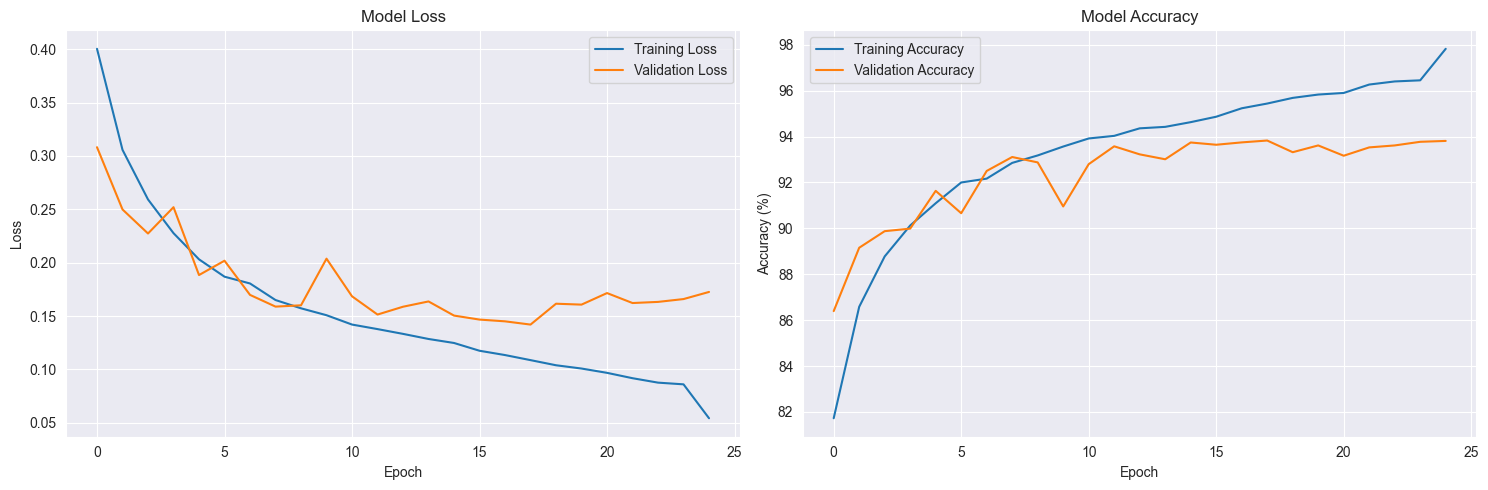

Loading best model for evaluation...
Test Accuracy: 0.9396

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.96     15600
      Stroke       0.94      0.88      0.91      7800

    accuracy                           0.94     23400
   macro avg       0.94      0.92      0.93     23400
weighted avg       0.94      0.94      0.94     23400



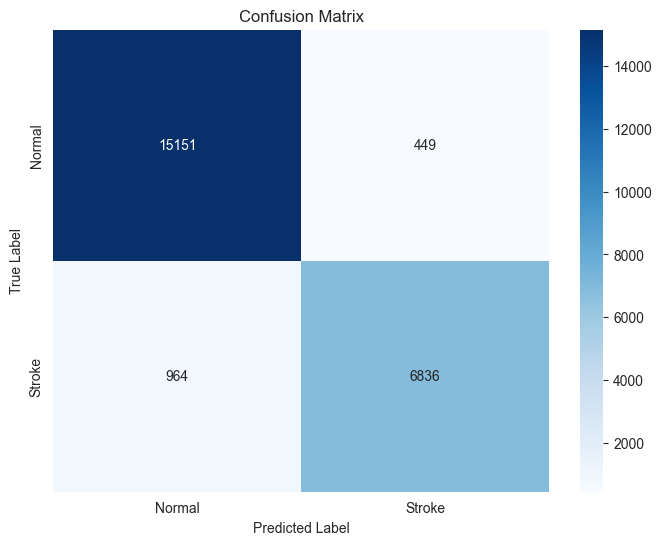

Final Test Accuracy: 0.9396


In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split  # <-- Add this
from transformers import ViTForImageClassification, ViTConfig  # Required for ViT
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainCTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_dataset(data_dir):
    """
    Load dataset from directory structure:
    data_dir/
        Stroke/
            image1.jpg
            image2.jpg
        Normal/
            image1.jpg
            image2.jpg
    """
    image_paths = []
    labels = []
    class_names = ['Normal', 'Stroke']  # 0: Normal, 1: Stroke

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_idx)

    return image_paths, labels, class_names

def create_data_augmentation():
    """Create comprehensive data augmentation for medical images"""

    # Training augmentation - aggressive for small datasets
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),  # Small rotation for medical images
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),  # Medical images can be flipped vertically
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),  # Convert to tensor BEFORE tensor-only transforms
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Move after ToTensor
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),  # Move after ToTensor
    ])

    # Validation/Test transform - no augmentation
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def split_data(image_paths, labels, test_size=0.2, val_size=0.2, random_state=42):
    """Split data into train, validation, and test sets"""

    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size,
        random_state=random_state, stratify=labels
    )

    # Second split: train vs val
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio,
        random_state=random_state, stratify=y_temp
    )

    print(f"Dataset split:")
    print(f"Train: {len(X_train)} images")
    print(f"Validation: {len(X_val)} images")
    print(f"Test: {len(X_test)} images")

    return X_train, X_val, X_test, y_train, y_val, y_test

class ViTBrainClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ViTBrainClassifier, self).__init__()

        if pretrained:
            # Use pre-trained ViT-Base
            self.vit = ViTForImageClassification.from_pretrained(
                'google/vit-base-patch16-224',
                num_labels=num_classes,
                ignore_mismatched_sizes=True
            )
        else:
            # Create ViT from scratch (for very small datasets)
            config = ViTConfig(
                image_size=224,
                patch_size=16,
                num_channels=3,
                num_classes=num_classes,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072
            )
            self.vit = ViTForImageClassification(config)

    def forward(self, x):
        outputs = self.vit(x)
        return outputs.logits

def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=1e-4):
    """Train the ViT model with early stopping"""

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    patience_counter = 0
    patience = 10

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}...")

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        print(f"Starting training loop with {len(train_loader)} batches...")

        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx == 0:
                print(f"Successfully loaded first batch: images shape {images.shape}, labels shape {labels.shape}")

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'Aug_dataset_vit_stroke.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_model(model, test_loader, class_names):
    """Evaluate the model on test set"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    DATA_DIR = "Aug_dataset"  # Update this path
    BATCH_SIZE = 32  # Small batch size for small datasets
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4

    # Load dataset
    print("Loading dataset...")
    image_paths, labels, class_names = load_dataset(DATA_DIR)
    print(f"Total images: {len(image_paths)}")
    print(f"Classes: {class_names}")
    print(f"Class distribution: Normal: {labels.count(0)}, Stroke: {labels.count(1)}")

    # Split dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(image_paths, labels)

    # Create data transforms
    train_transform, val_transform = create_data_augmentation()

    # Create datasets
    train_dataset = BrainCTDataset(X_train, y_train, transform=train_transform)
    val_dataset = BrainCTDataset(X_val, y_val, transform=val_transform)
    test_dataset = BrainCTDataset(X_test, y_test, transform=val_transform)

    # Create data loaders (set num_workers=0 for Windows compatibility)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Create model
    print("Creating ViT model...")
    model = ViTBrainClassifier(num_classes=len(class_names), pretrained=True)
    model = model.to(device)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Train model
    print("Starting training...")
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
    )

    # Plot training history
    plot_training_history(train_losses, train_accs, val_losses, val_accs)

    # Load best model and evaluate
    print("Loading best model for evaluation...")
    model.load_state_dict(torch.load('Aug_dataset_vit_stroke.pth'))
    test_accuracy = evaluate_model(model, test_loader, class_names)

    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    torch.save(model.state_dict(), 'Aug_dataset_vit_stroke.pth')
    torch.save(model, 'Aug_dataset_vit_stroke.h5')


if __name__ == "__main__":
    main()

# Additional utility functions for small datasets

def create_weighted_sampler(labels):
    """Create weighted sampler for imbalanced datasets"""
    from torch.utils.data import WeightedRandomSampler

    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def apply_mixup(data, targets, alpha=0.2):
    """Apply MixUp augmentation for small datasets"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = data.size(0)
    index = torch.randperm(batch_size)

    mixed_data = lam * data + (1 - lam) * data[index, :]
    targets_a, targets_b = targets, targets[index]

    return mixed_data, targets_a, targets_b, lam

def focal_loss(inputs, targets, alpha=1, gamma=2):
    """Focal loss for handling class imbalance"""
    ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
    pt = torch.exp(-ce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    return focal_loss.mean()

# Example usage for very small datasets (< 100 images):
def small_dataset_modifications():
    """
    For very small datasets, consider these modifications:

    1. Use stronger data augmentation
    2. Reduce model size or use smaller ViT variants
    3. Apply transfer learning with frozen early layers
    4. Use techniques like MixUp, CutMix
    5. Apply focal loss for class imbalance
    6. Use k-fold cross-validation instead of single split
    """

    # Example: Freeze early layers for transfer learning
    def freeze_early_layers(model, num_layers_to_freeze=6):
        for i, (name, param) in enumerate(model.vit.vit.encoder.layer.named_parameters()):
            if i < num_layers_to_freeze:
                param.requires_grad = False

    # Example: Use smaller learning rate and longer training
    optimizer_config = {
        'lr': 5e-5,  # Smaller learning rate
        'weight_decay': 0.01,
        'eps': 1e-8
    }

    return optimizer_config

BALANCED DATASET

Using device: cuda
Loading dataset...
Total images: 120000
Classes: ['Normal', 'Stroke']
Class distribution: Normal: 60000, Stroke: 60000
Dataset split:
Train: 72000 images
Validation: 24000 images
Test: 24000 images
Creating ViT model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85,800,194
Trainable parameters: 85,800,194
Starting training...
Starting epoch 1/25...
Starting training loop with 2250 batches...
Successfully loaded first batch: images shape torch.Size([32, 3, 224, 224]), labels shape torch.Size([32])
Epoch 1/25, Batch 1/2250, Loss: 0.6991
Epoch 1/25, Batch 11/2250, Loss: 0.7237
Epoch 1/25, Batch 21/2250, Loss: 0.6190
Epoch 1/25, Batch 31/2250, Loss: 0.5427
Epoch 1/25, Batch 41/2250, Loss: 0.5985
Epoch 1/25, Batch 51/2250, Loss: 0.5578
Epoch 1/25, Batch 61/2250, Loss: 1.1644
Epoch 1/25, Batch 71/2250, Loss: 0.5341
Epoch 1/25, Batch 81/2250, Loss: 0.5284
Epoch 1/25, Batch 91/2250, Loss: 0.3605
Epoch 1/25, Batch 101/2250, Loss: 0.4721
Epoch 1/25, Batch 111/2250, Loss: 0.4834
Epoch 1/25, Batch 121/2250, Loss: 0.4848
Epoch 1/25, Batch 131/2250, Loss: 0.5313
Epoch 1/25, Batch 141/2250, Loss: 0.4661
Epoch 1/25, Batch 151/2250, Loss: 0.4508
Epoch 1/25, Batch 161/2250, Loss: 0.4358
Epoch 1/25, Batch 171/2250, Loss: 0.4370
Epoch 1/25, Batc

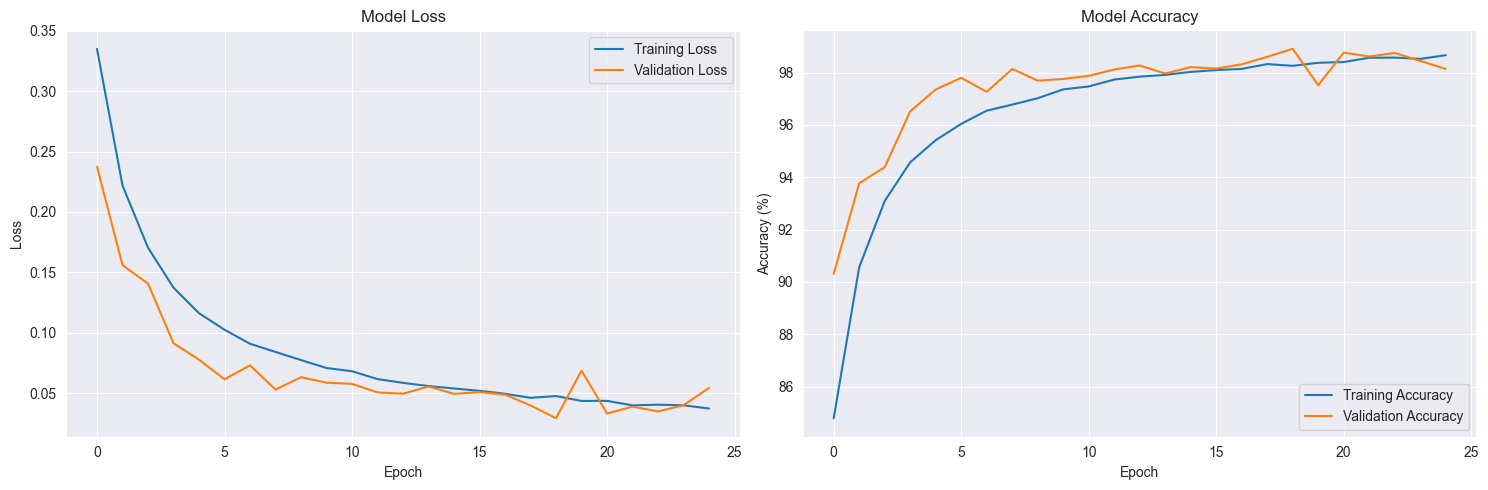

Loading best model for evaluation...
Test Accuracy: 0.9887

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     12000
      Stroke       0.99      0.99      0.99     12000

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



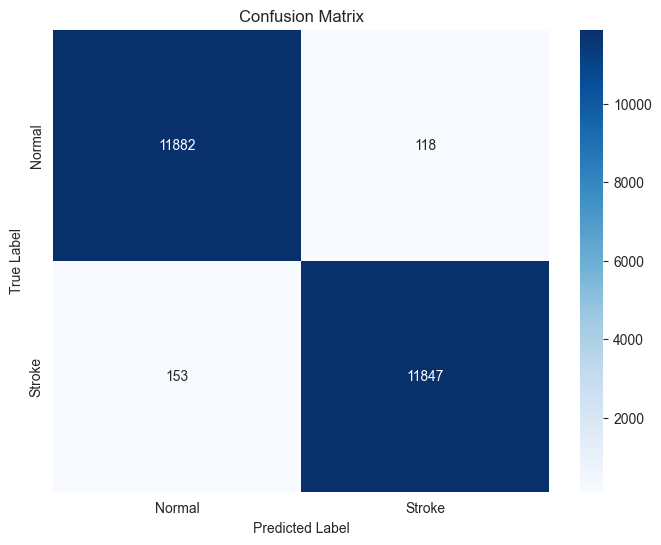

Final Test Accuracy: 0.9887


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTForImageClassification, ViTConfig
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainCTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_dataset(data_dir):
    """
    Load dataset from directory structure:
    data_dir/
        Stroke/
            image1.jpg
            image2.jpg
        Normal/
            image1.jpg
            image2.jpg
    """
    image_paths = []
    labels = []
    class_names = ['Normal', 'Stroke']  # 0: Normal, 1: Stroke

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_idx)

    return image_paths, labels, class_names

def create_data_augmentation():
    """Create comprehensive data augmentation for medical images"""

    # Training augmentation - aggressive for small datasets
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),  # Small rotation for medical images
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),  # Medical images can be flipped vertically
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),  # Convert to tensor BEFORE tensor-only transforms
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Move after ToTensor
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),  # Move after ToTensor
    ])

    # Validation/Test transform - no augmentation
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def split_data(image_paths, labels, test_size=0.2, val_size=0.2, random_state=42):
    """Split data into train, validation, and test sets"""

    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size,
        random_state=random_state, stratify=labels
    )

    # Second split: train vs val
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio,
        random_state=random_state, stratify=y_temp
    )

    print(f"Dataset split:")
    print(f"Train: {len(X_train)} images")
    print(f"Validation: {len(X_val)} images")
    print(f"Test: {len(X_test)} images")

    return X_train, X_val, X_test, y_train, y_val, y_test

class ViTBrainClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ViTBrainClassifier, self).__init__()

        if pretrained:
            # Use pre-trained ViT-Base
            self.vit = ViTForImageClassification.from_pretrained(
                'google/vit-base-patch16-224',
                num_labels=num_classes,
                ignore_mismatched_sizes=True
            )
        else:
            # Create ViT from scratch (for very small datasets)
            config = ViTConfig(
                image_size=224,
                patch_size=16,
                num_channels=3,
                num_classes=num_classes,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072
            )
            self.vit = ViTForImageClassification(config)

    def forward(self, x):
        outputs = self.vit(x)
        return outputs.logits

def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=1e-4):
    """Train the ViT model with early stopping"""

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    patience_counter = 0
    patience = 10

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}...")

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        print(f"Starting training loop with {len(train_loader)} batches...")

        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx == 0:
                print(f"Successfully loaded first batch: images shape {images.shape}, labels shape {labels.shape}")

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'Balanced_dataset_vit_stroke.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_model(model, test_loader, class_names):
    """Evaluate the model on test set"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    DATA_DIR = "Balanced_dataset"  # Update this path
    BATCH_SIZE = 32  # Small batch size for small datasets
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4

    # Load dataset
    print("Loading dataset...")
    image_paths, labels, class_names = load_dataset(DATA_DIR)
    print(f"Total images: {len(image_paths)}")
    print(f"Classes: {class_names}")
    print(f"Class distribution: Normal: {labels.count(0)}, Stroke: {labels.count(1)}")

    # Split dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(image_paths, labels)

    # Create data transforms
    train_transform, val_transform = create_data_augmentation()

    # Create datasets
    train_dataset = BrainCTDataset(X_train, y_train, transform=train_transform)
    val_dataset = BrainCTDataset(X_val, y_val, transform=val_transform)
    test_dataset = BrainCTDataset(X_test, y_test, transform=val_transform)

    # Create data loaders (set num_workers=0 for Windows compatibility)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Create model
    print("Creating ViT model...")
    model = ViTBrainClassifier(num_classes=len(class_names), pretrained=True)
    model = model.to(device)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Train model
    print("Starting training...")
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
    )

    # Plot training history
    plot_training_history(train_losses, train_accs, val_losses, val_accs)

    # Load best model and evaluate
    print("Loading best model for evaluation...")
    model.load_state_dict(torch.load('Balanced_dataset_vit_stroke.pth'))
    test_accuracy = evaluate_model(model, test_loader, class_names)

    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    torch.save(model.state_dict(), 'Balanced_dataset_vit_stroke.pth')
    torch.save(model, 'Balanced_dataset_vit_stroke.h5')


if __name__ == "__main__":
    main()

# Additional utility functions for small datasets

def create_weighted_sampler(labels):
    """Create weighted sampler for imbalanced datasets"""
    from torch.utils.data import WeightedRandomSampler

    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def apply_mixup(data, targets, alpha=0.2):
    """Apply MixUp augmentation for small datasets"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = data.size(0)
    index = torch.randperm(batch_size)

    mixed_data = lam * data + (1 - lam) * data[index, :]
    targets_a, targets_b = targets, targets[index]

    return mixed_data, targets_a, targets_b, lam

def focal_loss(inputs, targets, alpha=1, gamma=2):
    """Focal loss for handling class imbalance"""
    ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
    pt = torch.exp(-ce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    return focal_loss.mean()

# Example usage for very small datasets (< 100 images):
def small_dataset_modifications():
    """
    For very small datasets, consider these modifications:

    1. Use stronger data augmentation
    2. Reduce model size or use smaller ViT variants
    3. Apply transfer learning with frozen early layers
    4. Use techniques like MixUp, CutMix
    5. Apply focal loss for class imbalance
    6. Use k-fold cross-validation instead of single split
    """

    # Example: Freeze early layers for transfer learning
    def freeze_early_layers(model, num_layers_to_freeze=6):
        for i, (name, param) in enumerate(model.vit.vit.encoder.layer.named_parameters()):
            if i < num_layers_to_freeze:
                param.requires_grad = False

    # Example: Use smaller learning rate and longer training
    optimizer_config = {
        'lr': 5e-5,  # Smaller learning rate
        'weight_decay': 0.01,
        'eps': 1e-8
    }

    return optimizer_config

In [7]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

# -----------------------------
# Settings & Hyperparameters
# -----------------------------
data_dir = "Aug_dataset"
batch_size = 32  # reduce if using GPU with <6GB memory
img_size = 224
val_split = 0.2
test_split = 0.2
seed = 42
num_workers = 4  # increase if your CPU can handle it
epochs = 25

# -----------------------------
# Transforms
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# Dataset Loading & Splitting
# -----------------------------
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

total_size = len(dataset)
val_size = int(val_split * total_size)
test_size = int(test_split * total_size)
train_size = total_size - val_size - test_size

print(f"Total samples: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")
print(f"Class names: {class_names}")

train_set, val_set, test_set = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# -----------------------------
# Device Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Model: VGG16 + Fine-tuned Classifier
# -----------------------------
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)  # 2 classes: Stroke and Normal
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, dataloader, silent=False):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = correct / total
    if not silent:
        print(classification_report(y_true, y_pred, target_names=class_names))
    return acc

# -----------------------------
# Training Function
# -----------------------------
def train_model(model, epochs=10):
    best_acc = 0
    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Batch progress logging
            if batch_idx % 15 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] "
                      f"Step [{batch_idx}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f}")

        # Epoch summary
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, silent=True)
        print(f"Epoch [{epoch+1}/{epochs}] completed in {time.time() - start:.2f}s")
        print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}\n")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "Aug_dataset_vgg16_stroke.pth")
            print(f"✅ Best model updated and saved with Val Acc: {val_acc:.4f}\n")

# -----------------------------
# Run Training
# -----------------------------
train_model(model, epochs=epochs)
# Load and Test the Best Model
# -----------------------------
model.load_state_dict(torch.load("Aug_dataset_vgg16_stroke.pth"))
print("\n📊 Final Test Set Evaluation:")
evaluate_model(model, test_loader)

Total samples: 117000
Train: 70200, Val: 23400, Test: 23400
Class names: ['Normal', 'Stroke']
Using device: cuda
Epoch [1/25] Step [0/2194] Loss: 0.9279
Epoch [1/25] Step [15/2194] Loss: 0.7384
Epoch [1/25] Step [30/2194] Loss: 0.5932
Epoch [1/25] Step [45/2194] Loss: 0.6098
Epoch [1/25] Step [60/2194] Loss: 0.5120
Epoch [1/25] Step [75/2194] Loss: 0.4761
Epoch [1/25] Step [90/2194] Loss: 0.5898
Epoch [1/25] Step [105/2194] Loss: 0.6871
Epoch [1/25] Step [120/2194] Loss: 0.5656
Epoch [1/25] Step [135/2194] Loss: 0.6564
Epoch [1/25] Step [150/2194] Loss: 0.6179
Epoch [1/25] Step [165/2194] Loss: 0.5614
Epoch [1/25] Step [180/2194] Loss: 0.5424
Epoch [1/25] Step [195/2194] Loss: 0.5936
Epoch [1/25] Step [210/2194] Loss: 0.3963
Epoch [1/25] Step [225/2194] Loss: 0.6791
Epoch [1/25] Step [240/2194] Loss: 0.5000
Epoch [1/25] Step [255/2194] Loss: 0.5550
Epoch [1/25] Step [270/2194] Loss: 0.6386
Epoch [1/25] Step [285/2194] Loss: 0.5601
Epoch [1/25] Step [300/2194] Loss: 0.5851
Epoch [1/25] 

0.8974786324786325

In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

# -----------------------------
# Settings & Hyperparameters
# -----------------------------
data_dir = "Balanced_dataset"
batch_size = 32  # reduce if using GPU with <6GB memory
img_size = 224
val_split = 0.2
test_split = 0.2
seed = 42
num_workers = 4  # increase if your CPU can handle it
epochs = 25

# -----------------------------
# Transforms
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# Dataset Loading & Splitting
# -----------------------------
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

total_size = len(dataset)
val_size = int(val_split * total_size)
test_size = int(test_split * total_size)
train_size = total_size - val_size - test_size

print(f"Total samples: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")
print(f"Class names: {class_names}")

train_set, val_set, test_set = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# -----------------------------
# Device Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Model: VGG16 + Fine-tuned Classifier
# -----------------------------
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)  # 2 classes: Stroke and Normal
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, dataloader, silent=False):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = correct / total
    if not silent:
        print(classification_report(y_true, y_pred, target_names=class_names))
    return acc

# -----------------------------
# Training Function
# -----------------------------
def train_model(model, epochs=10):
    best_acc = 0
    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Batch progress logging
            if batch_idx % 15 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] "
                      f"Step [{batch_idx}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f}")

        # Epoch summary
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, silent=True)
        print(f"Epoch [{epoch+1}/{epochs}] completed in {time.time() - start:.2f}s")
        print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}\n")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "Balanced_dataset_vgg16_stroke.pth")
            print(f"✅ Best model updated and saved with Val Acc: {val_acc:.4f}\n")

# -----------------------------
# Run Training
# -----------------------------
train_model(model, epochs=epochs)
# Load and Test the Best Model
# -----------------------------
model.load_state_dict(torch.load("Balanced_dataset_vgg16_stroke.pth"))
print("\n📊 Final Test Set Evaluation:")
evaluate_model(model, test_loader)

Total samples: 120000
Train: 72000, Val: 24000, Test: 24000
Class names: ['Normal', 'Stroke']
Using device: cuda
Epoch [1/25] Step [0/2250] Loss: 0.7692
Epoch [1/25] Step [15/2250] Loss: 0.6561
Epoch [1/25] Step [30/2250] Loss: 0.7342
Epoch [1/25] Step [45/2250] Loss: 0.6003
Epoch [1/25] Step [60/2250] Loss: 0.5656
Epoch [1/25] Step [75/2250] Loss: 0.5169
Epoch [1/25] Step [90/2250] Loss: 0.5492
Epoch [1/25] Step [105/2250] Loss: 0.6450
Epoch [1/25] Step [120/2250] Loss: 0.5099
Epoch [1/25] Step [135/2250] Loss: 0.5714
Epoch [1/25] Step [150/2250] Loss: 0.4540
Epoch [1/25] Step [165/2250] Loss: 0.4783
Epoch [1/25] Step [180/2250] Loss: 0.5054
Epoch [1/25] Step [195/2250] Loss: 0.6689
Epoch [1/25] Step [210/2250] Loss: 0.3816
Epoch [1/25] Step [225/2250] Loss: 0.7756
Epoch [1/25] Step [240/2250] Loss: 0.4676
Epoch [1/25] Step [255/2250] Loss: 0.4071
Epoch [1/25] Step [270/2250] Loss: 0.5913
Epoch [1/25] Step [285/2250] Loss: 0.6049
Epoch [1/25] Step [300/2250] Loss: 0.2978
Epoch [1/25] 

0.955